<a href="https://colab.research.google.com/github/Cansuuzum-38/Comparative-ML-and-TransferLearning-using-Fruit-Dataset/blob/main/Fruits_Dataset_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Kaggle kütüphanesini yükle
!pip install -q kaggle

In [5]:
# Kaggle API anahtarını yüklemek için
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cansuzm","key":"f524ddd4c9527f39ec453e01f1f14792"}'}

In [6]:
# Doğru dizine taşı ve izin ver
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Veri setini indir
!kaggle datasets download -d shreyapmaher/fruits-dataset-images

Dataset URL: https://www.kaggle.com/datasets/shreyapmaher/fruits-dataset-images
License(s): other


In [8]:
# Zip dosyasını çıkart
import zipfile
with zipfile.ZipFile("fruits-dataset-images.zip", 'r') as zip_ref:
    zip_ref.extractall("fruits_dataset")


In [9]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
def load_images_from_folder(folder, img_size=(64, 64)):
    X, y = [], []
    for class_folder in os.listdir(folder):
        class_path = os.path.join(folder, class_folder)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Griye çevir
                X.append(img.flatten())  # Tek boyuta indir
                y.append(class_folder)
    return np.array(X), np.array(y)

X, y = load_images_from_folder("fruits_dataset/images")
print("Görsel sayısı:", X.shape[0])
print("Her görselin vektör boyutu:", X.shape[1])


Görsel sayısı: 359
Her görselin vektör boyutu: 4096


In [16]:
def load_color_images_with_augmentation(folder, img_size=(128, 128)):
    X, y = [], []
    from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for class_folder in os.listdir(folder):
        class_path = os.path.join(folder, class_folder)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                img = img / 255.0  # normalize
                X.append(img.flatten())
                y.append(class_folder)

                # Veri artırma – sadece bir örnekle yapalım (bir görüntüden +2 varyasyon)
                img_reshaped = np.expand_dims(img, axis=0)
                i = 0
                for batch in datagen.flow(img_reshaped, batch_size=1):
                    X.append(batch[0].flatten())
                    y.append(class_folder)
                    i += 1
                    if i >= 2:  # Her görüntüden 2 varyasyon üret
                        break
            except:
                continue
    return np.array(X), np.array(y)


# **VERİLERİ YÜKLEME**

In [17]:
X_aug, y_aug = load_color_images_with_augmentation("fruits_dataset/images")
print("Toplam örnek sayısı (artırılmış):", len(X_aug))

Toplam örnek sayısı (artırılmış): 1077


# **ENCODE+SCALE+TRAIN-TEST SPLIT**

In [18]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y_encoded = le.fit_transform(y_aug)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_aug)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)


=== Logistic Regression (Renkli ve Artırılmış Görseller) ===
Accuracy: 0.4722222222222222
                  precision    recall  f1-score   support

     apple fruit       0.30      0.35      0.32        17
    banana fruit       0.52      0.54      0.53        28
    cherry fruit       0.57      0.50      0.53        26
   chickoo fruit       0.29      0.30      0.30        23
    grapes fruit       0.47      0.52      0.49        29
      kiwi fruit       0.53      0.48      0.50        21
     mango fruit       0.37      0.29      0.33        24
    orange fruit       0.57      0.74      0.64        23
strawberry fruit       0.60      0.48      0.53        25

        accuracy                           0.47       216
       macro avg       0.47      0.47      0.46       216
    weighted avg       0.47      0.47      0.47       216



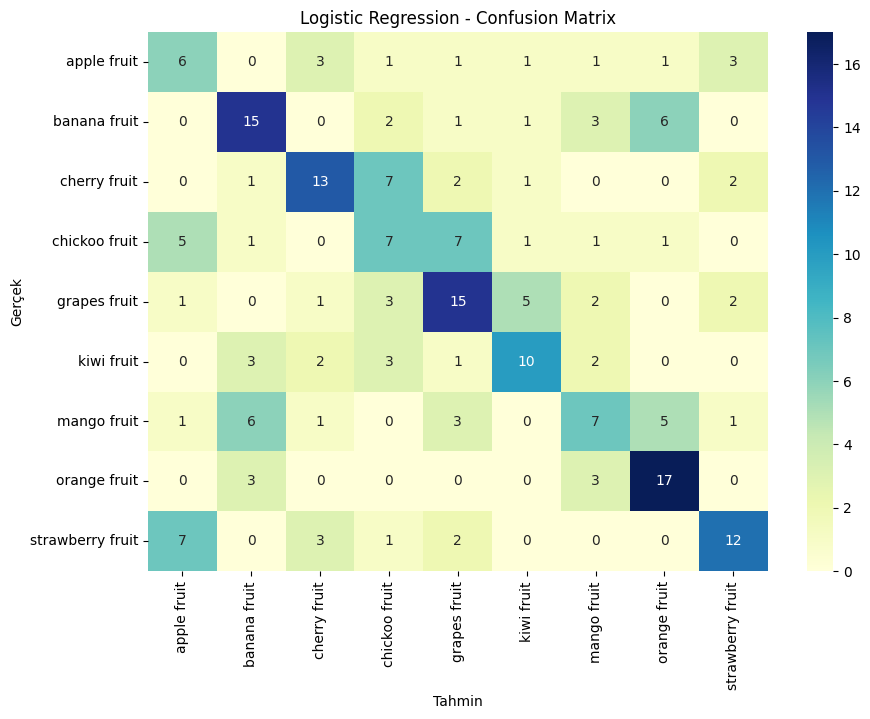

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Modeli oluştur ve eğit
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Tahmin yap
y_pred_lr = logreg.predict(X_test)

# Metrikleri yazdır
print("=== Logistic Regression (Renkli ve Artırılmış Görseller) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

# Confusion Matrix çizimi
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='YlGnBu')
    plt.xlabel("Tahmin")
    plt.ylabel("Gerçek")
    plt.title(title)
    plt.show()

plot_confusion(y_test, y_pred_lr, "Logistic Regression - Confusion Matrix")


## DENGELİ VERİ ARTIRMA

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import os

def load_images_with_light_augmentation(folder, img_size=(128, 128), augment_count=2):
    X, y = [], []

    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for class_folder in os.listdir(folder):
        class_path = os.path.join(folder, class_folder)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                img = img / 255.0
                X.append(img.flatten())
                y.append(class_folder)

                # optimize: her görüntüden yalnızca 2 yeni varyasyon
                img_reshaped = np.expand_dims(img, axis=0)
                i = 0
                for batch in datagen.flow(img_reshaped, batch_size=1):
                    X.append(batch[0].flatten())
                    y.append(class_folder)
                    i += 1
                    if i >= augment_count:
                        break
            except:
                continue
    return np.array(X), np.array(y)


## **VERİYİ ALMA**

In [28]:
X_opt_aug, y_opt_aug = load_images_with_light_augmentation("fruits_dataset/images")
print("Optimize edilmiş örnek sayısı:", len(X_opt_aug))

Optimize edilmiş örnek sayısı: 1077


## **ENCODE+ NORMALIZE+SPLIT**

In [29]:
# Encode + Normalize+ Split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y_encoded = le.fit_transform(y_opt_aug)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_opt_aug)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)


## **LOGISTIC REGRESSION**

=== Logistic Regression (Optimize Augmentation) ===
Accuracy: 0.5925925925925926
                  precision    recall  f1-score   support

     apple fruit       0.44      0.47      0.46        17
    banana fruit       0.64      0.50      0.56        28
    cherry fruit       0.62      0.69      0.65        26
   chickoo fruit       0.35      0.39      0.37        23
    grapes fruit       0.59      0.59      0.59        29
      kiwi fruit       0.76      0.62      0.68        21
     mango fruit       0.38      0.38      0.38        24
    orange fruit       0.68      0.91      0.78        23
strawberry fruit       0.95      0.76      0.84        25

        accuracy                           0.59       216
       macro avg       0.60      0.59      0.59       216
    weighted avg       0.61      0.59      0.59       216



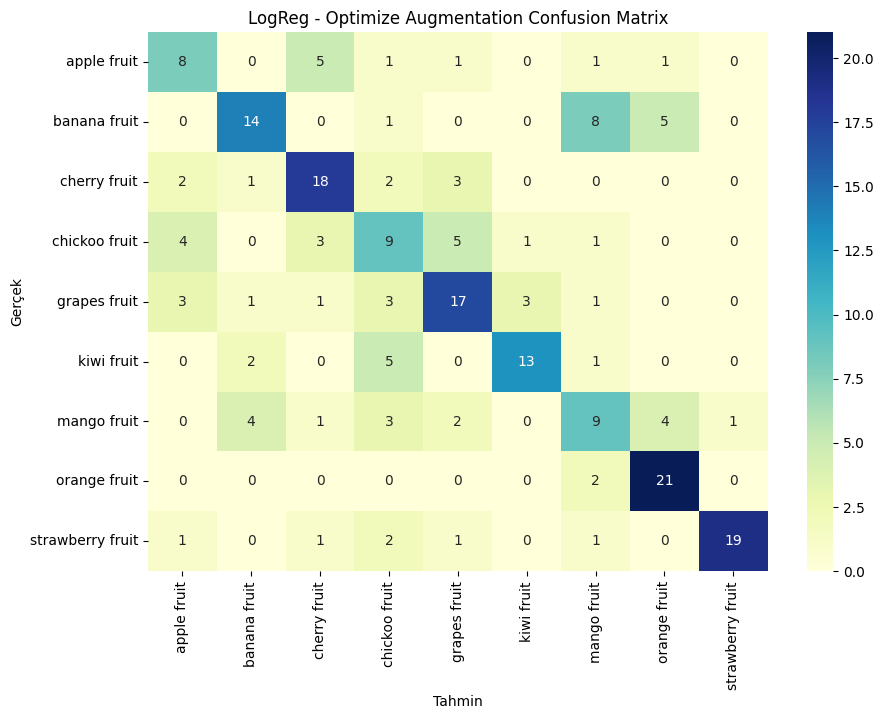

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print("=== Logistic Regression (Optimize Augmentation) ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='YlGnBu')
    plt.xlabel("Tahmin")
    plt.ylabel("Gerçek")
    plt.title(title)
    plt.show()

plot_confusion(y_test, y_pred, "LogReg - Optimize Augmentation Confusion Matrix")


## **RANDOM FOREST**

=== Random Forest ===
Accuracy: 0.7361111111111112
                  precision    recall  f1-score   support

     apple fruit       0.60      0.71      0.65        17
    banana fruit       0.75      0.75      0.75        28
    cherry fruit       0.78      0.81      0.79        26
   chickoo fruit       0.70      0.61      0.65        23
    grapes fruit       0.68      0.72      0.70        29
      kiwi fruit       0.79      0.71      0.75        21
     mango fruit       0.60      0.62      0.61        24
    orange fruit       0.81      0.96      0.88        23
strawberry fruit       0.95      0.72      0.82        25

        accuracy                           0.74       216
       macro avg       0.74      0.73      0.73       216
    weighted avg       0.74      0.74      0.74       216



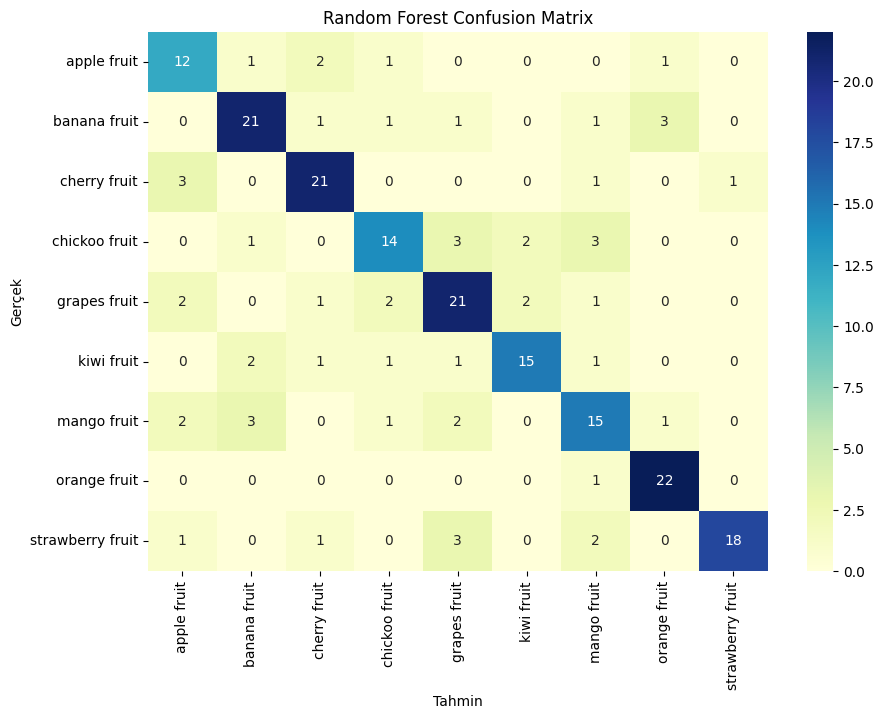

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modeli tanımla ve eğit
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Tahmin yap
y_pred_rf = rf_model.predict(X_test)

# Sonuçları yazdır
print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Confusion Matrix
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='YlGnBu')
    plt.xlabel("Tahmin")
    plt.ylabel("Gerçek")
    plt.title(title)
    plt.show()

plot_confusion(y_test, y_pred_rf, "Random Forest Confusion Matrix")


## SVM

=== SVM (RBF Kernel) ===
Accuracy: 0.8425925925925926
                  precision    recall  f1-score   support

     apple fruit       0.75      0.88      0.81        17
    banana fruit       0.88      0.79      0.83        28
    cherry fruit       0.95      0.81      0.88        26
   chickoo fruit       0.72      0.78      0.75        23
    grapes fruit       0.81      0.90      0.85        29
      kiwi fruit       1.00      0.81      0.89        21
     mango fruit       0.81      0.88      0.84        24
    orange fruit       0.81      0.91      0.86        23
strawberry fruit       0.91      0.84      0.88        25

        accuracy                           0.84       216
       macro avg       0.85      0.84      0.84       216
    weighted avg       0.85      0.84      0.84       216



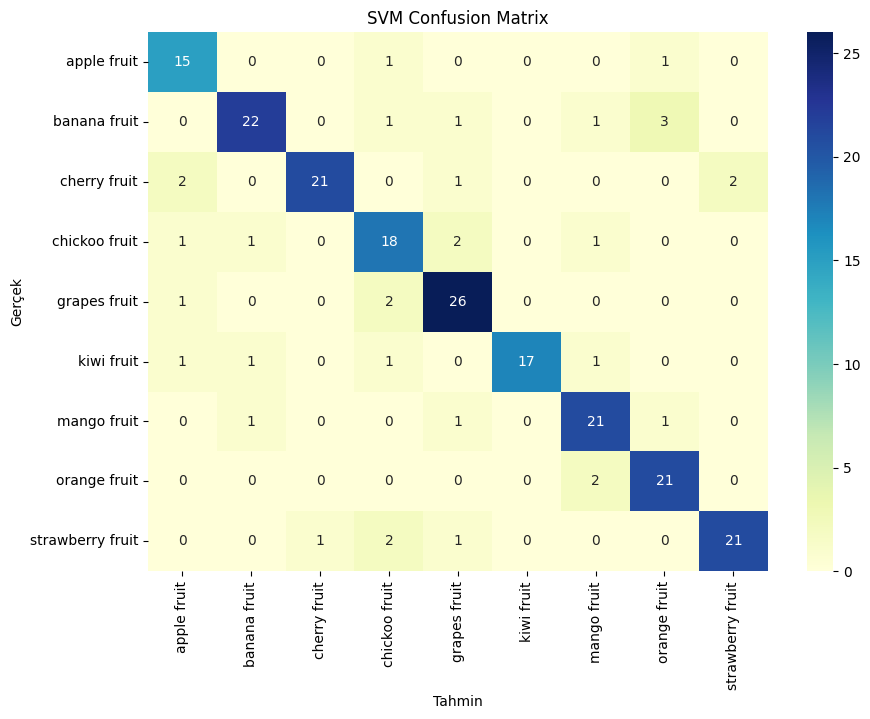

In [32]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modeli tanımla ve eğit
svm_model = SVC(kernel='rbf', C=10, gamma='scale')  # 'rbf' çekirdeği genelde en iyi sonucu verir
svm_model.fit(X_train, y_train)

# Tahmin yap
y_pred_svm = svm_model.predict(X_test)

# Sonuçları yazdır
print("=== SVM (RBF Kernel) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

# Confusion Matrix çizimi
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='YlGnBu')
    plt.xlabel("Tahmin")
    plt.ylabel("Gerçek")
    plt.title(title)
    plt.show()

plot_confusion(y_test, y_pred_svm, "SVM Confusion Matrix")


## **KNN**

=== KNN (k=3) ===
Accuracy: 0.6157407407407407
                  precision    recall  f1-score   support

     apple fruit       0.31      0.71      0.43        17
    banana fruit       0.68      0.82      0.74        28
    cherry fruit       0.75      0.35      0.47        26
   chickoo fruit       0.50      0.57      0.53        23
    grapes fruit       0.80      0.41      0.55        29
      kiwi fruit       0.80      0.76      0.78        21
     mango fruit       0.58      0.62      0.60        24
    orange fruit       0.73      0.83      0.78        23
strawberry fruit       0.78      0.56      0.65        25

        accuracy                           0.62       216
       macro avg       0.66      0.63      0.61       216
    weighted avg       0.67      0.62      0.62       216



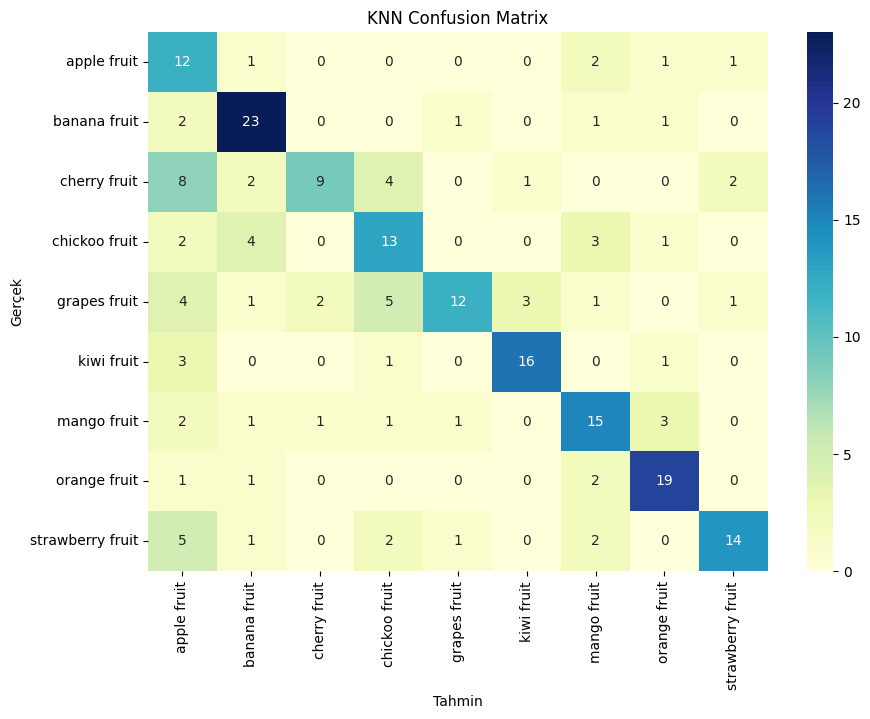

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# KNN modeli
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

# Tahmin yap
y_pred_knn = knn_model.predict(X_test)

# Sonuçları yazdır
print("=== KNN (k=3) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

# Confusion Matrix
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='YlGnBu')
    plt.xlabel("Tahmin")
    plt.ylabel("Gerçek")
    plt.title(title)
    plt.show()

plot_confusion(y_test, y_pred_knn, "KNN Confusion Matrix")
